<a href="https://colab.research.google.com/github/santiagoql/HEU/blob/main/Heu2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto 2: Metaheurísticas Aleatorizadas para Balanceo de Sistemas PTL**


## **Descripción de los Métodos Utilizados**

En este proyecto se implementan y comparan dos enfoques para la asignación de pedidos en un sistema **Pick-to-Light (PTL)**, con el objetivo de **minimizar la carga máxima** en las zonas de trabajo:

- Un **método constructivo (heurística voraz)** que asigna los pedidos de manera secuencial.
- Un **método aleatorizado basado en Recocido Simulado (Simulated Annealing)**, que explora múltiples soluciones para mejorar la asignación inicial.

Se comparan ambos métodos en términos de **calidad de la solución** y **tiempo de cómputo**, utilizando un conjunto de instancias de prueba.


## **1. Método Constructivo (Heurística Greedy)**

Este método sigue una estrategia determinística para asignar los pedidos a las salidas del sistema PTL, buscando equilibrar la carga entre zonas de manera directa.

### **Descripción**
- Se recorren los pedidos en orden y se asignan secuencialmente a las salidas disponibles.
- Se intenta distribuir la carga de manera equitativa entre las zonas.
- No se realizan ajustes posteriores ni exploración de soluciones alternativas.

### **Ventajas y Desventajas**
✅ **Ventajas:** Método rápido y computacionalmente eficiente.  
❌ **Desventajas:** Puede generar soluciones subóptimas debido a su naturaleza determinista.


## **2. Método Aleatorizado (Recocido Simulado - Simulated Annealing, SA)**

El **Recocido Simulado (Simulated Annealing, SA)** es una técnica inspirada en el proceso de enfriamiento de metales, que permite la exploración de soluciones mediante cambios aleatorios controlados.

### **Descripción Matemática**
Dado un conjunto de pedidos \( P \), salidas \( S \) y zonas \( Z \), el objetivo es minimizar la carga máxima en cualquier zona:

\[
\min \max_{z \in Z} C_z
\]

donde \( C_z \) representa la carga total en la zona \( z \), calculada como:

\[
C_z = \sum_{p \in P_z} \frac{T_p + 2 (d_{pz} / v)}{\text{prod}(T_z)}
\]

- \( T_p \) es el tiempo de preparación del pedido \( p \).
- \( d_{pz} \) es la distancia a la zona \( z \).
- \( v \) es la velocidad de desplazamiento.
- \( \text{prod}(T_z) \) es la productividad del trabajador asignado a \( z \).


## **Algoritmo en Pseudocódigo**

```plaintext
1. Inicializar temperatura T = T_INICIAL
2. Generar una solución inicial aleatoria
3. Evaluar la carga máxima de la solución inicial
4. Mientras T > T_FINAL:
    5. Repetir ITERACIONES_POR_TEMPERATURA veces:
        6. Generar una solución vecina modificando la asignación de un pedido
        7. Evaluar la carga máxima de la nueva solución
        8. Si la nueva solución es mejor, aceptarla
        9. Si es peor, aceptarla con probabilidad exp(-delta / T)
    10. Reducir la temperatura: T = T * FACTOR_ENFRIAMIENTO
11. Retornar la mejor solución encontrada



---

### **Representación de Soluciones y Perturbación**


solucion = {
    "Pedido_001": ("S034", "Z1"),
    "Pedido_002": ("S056", "Z2"),
    ...
}



---

### **Comparación de Métodos**


## **Comparación de Métodos**

| Método               | Estrategia     | Exploración | Calidad de solución | Tiempo de cómputo |
|----------------------|---------------|-------------|---------------------|------------------|
| **Greedy (Constructivo)** | Determinista  | Baja        | Subóptima           | Rápido |
| **Recocido Simulado (SA)** | Aleatorizada | Alta        | Mejor equilibrio    | Mayor |

El **Recocido Simulado** es capaz de encontrar soluciones más balanceadas al permitir cambios aleatorios y exploración del espacio de búsqueda, aunque a costa de un mayor tiempo de cómputo en comparación con la heurística constructiva.

## 80 Homogenea

Aleatorizado

In [ ]:
import pandas as pd
import os
import numpy as np
import time

# Parámetros del Recocido Simulado
T_INICIAL = 1000  # Temperatura inicial
T_FINAL = 1  # Temperatura final
FACTOR_ENFRIAMIENTO = 0.95  # Factor de enfriamiento
ITERACIONES_POR_TEMPERATURA = 80

def evaluar_solucion(asignaciones, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v):
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]
    return carga

def generar_vecino(asignaciones, posiciones_disponibles):
    nuevo_asignaciones = asignaciones.copy()
    pedido_cambiar = np.random.choice(list(nuevo_asignaciones.keys()))
    zona_actual = nuevo_asignaciones[pedido_cambiar][1]
    zonas_posibles = list(posiciones_disponibles.keys())
    if zona_actual in zonas_posibles:
        zonas_posibles.remove(zona_actual)
    if not zonas_posibles:
        return nuevo_asignaciones  # No hay zonas disponibles para cambiar
    nueva_zona = np.random.choice(zonas_posibles)
    nueva_salida = np.random.choice(posiciones_disponibles[nueva_zona])
    nuevo_asignaciones[pedido_cambiar] = (nueva_salida, nueva_zona)
    return nuevo_asignaciones

def recocido_simulado():
    start_time = time.time()
    file_path = "/content/Data_80_Salidas_composición_zonas_homogéneas.xlsx"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Inicializar asignaciones
    asignaciones = {}
    for pedido in tiempos_pedidos.keys():
        zona = np.random.choice(zonas_disponibles)
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)

    # Recocido Simulado
    T = T_INICIAL
    mejor_solucion = asignaciones.copy()
    mejor_carga = evaluar_solucion(mejor_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
    while T > T_FINAL:
        for _ in range(ITERACIONES_POR_TEMPERATURA):
            nueva_solucion = generar_vecino(mejor_solucion, posiciones)
            nueva_carga = evaluar_solucion(nueva_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
            delta = max(nueva_carga.values()) - max(mejor_carga.values())
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                mejor_solucion = nueva_solucion.copy()
                mejor_carga = nueva_carga.copy()
        T *= FACTOR_ENFRIAMIENTO

    # Guardar resultados en las tres hojas
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in mejor_solucion.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_80_Salidas_composición_zonas_homogéneas", "Zona": max(mejor_carga, key=mejor_carga.get), "Maximo": max(mejor_carga.values())}])
    df_met = pd.DataFrame([[zona, mejor_carga[zona]] for zona in mejor_carga.keys()], columns=["Zona", "Carga final"])
    output_file = "SolucionPTL_Aleatorizado_HO80.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Recocido Simulado: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    recocido_simulado()


Recocido Simulado: Archivo generado: SolucionPTL_Aleatorizado_HO80.xlsx
Tiempo de ejecución: 6.41 segundos
Resumen:
                                      Instancia Zona      Maximo
0  Data_80_Salidas_composición_zonas_homogéneas   Z4  378.869058
Solucion:
       Pedido Salida Zona
0    Pedido_1   S019   Z1
1    Pedido_2   S056   Z3
2    Pedido_3   S078   Z4
3    Pedido_4   S058   Z3
4    Pedido_5   S019   Z1
..        ...    ...  ...
75  Pedido_76   S038   Z2
76  Pedido_77   S005   Z1
77  Pedido_78   S006   Z1
78  Pedido_79   S017   Z1
79  Pedido_80   S018   Z1

[80 rows x 3 columns]
Metricas:
  Zona  Carga final
0   Z1   368.346411
1   Z2   375.647408
2   Z3   373.699849
3   Z4   378.869058


Constructivo

In [ ]:
import pandas as pd
import os
import numpy as np
import time

def metodo_constructivo():
    start_time = time.time()
    file_path = "/content/Data_80_Salidas_composición_zonas_homogéneas.xlsx"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    # Cargar datos desde el archivo Excel
    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    # Obtener zonas disponibles y posiciones en cada zona
    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Asignaciones iniciales con una estrategia constructiva
    asignaciones = {}
    pedidos = list(tiempos_pedidos.keys())
    pedidos.sort()  # Ordenamos los pedidos para asignarlos de manera estructurada
    zona_index = 0  # Para iterar sobre las zonas de forma balanceada

    for pedido in pedidos:
        zona = zonas_disponibles[zona_index % len(zonas_disponibles)]
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)
        zona_index += 1

    # Evaluar la solución
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]

    # Guardar resultados en las tres hojas del Excel
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in asignaciones.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_80_Salidas_composición_zonas_homogéneas", "Zona": max(carga, key=carga.get), "Maximo": max(carga.values())}])
    df_met = pd.DataFrame([[zona, carga[zona]] for zona in carga.keys()], columns=["Zona", "Carga final"])

    output_file = "SolucionPTL_Constructivo_HO80.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Método Constructivo: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    metodo_constructivo()


Método Constructivo: Archivo generado: SolucionPTL_Constructivo_HO80.xlsx
Tiempo de ejecución: 1.03 segundos
Resumen:
                                      Instancia Zona      Maximo
0  Data_80_Salidas_composición_zonas_homogéneas   Z3  387.642532
Solucion:
       Pedido Salida Zona
0    Pedido_1   S003   Z1
1   Pedido_10   S025   Z2
2   Pedido_11   S055   Z3
3   Pedido_12   S066   Z4
4   Pedido_13   S018   Z1
..        ...    ...  ...
75  Pedido_78   S066   Z4
76  Pedido_79   S011   Z1
77   Pedido_8   S036   Z2
78  Pedido_80   S041   Z3
79   Pedido_9   S076   Z4

[80 rows x 3 columns]
Metricas:
  Zona  Carga final
0   Z1   377.396154
1   Z2   344.570570
2   Z3   387.642532
3   Z4   387.407875


## 80 Heterogenea

Aleatorizado

In [ ]:
import pandas as pd
import os
import numpy as np
import time

# Parámetros del Recocido Simulado
T_INICIAL = 1000  # Temperatura inicial
T_FINAL = 1  # Temperatura final
FACTOR_ENFRIAMIENTO = 0.95  # Factor de enfriamiento
ITERACIONES_POR_TEMPERATURA = 80

def evaluar_solucion(asignaciones, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v):
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]
    return carga

def generar_vecino(asignaciones, posiciones_disponibles):
    nuevo_asignaciones = asignaciones.copy()
    pedido_cambiar = np.random.choice(list(nuevo_asignaciones.keys()))
    zona_actual = nuevo_asignaciones[pedido_cambiar][1]
    zonas_posibles = list(posiciones_disponibles.keys())
    if zona_actual in zonas_posibles:
        zonas_posibles.remove(zona_actual)
    if not zonas_posibles:
        return nuevo_asignaciones  # No hay zonas disponibles para cambiar
    nueva_zona = np.random.choice(zonas_posibles)
    nueva_salida = np.random.choice(posiciones_disponibles[nueva_zona])
    nuevo_asignaciones[pedido_cambiar] = (nueva_salida, nueva_zona)
    return nuevo_asignaciones

def recocido_simulado():
    start_time = time.time()
    file_path = "/content/Data_80_Salidas_composición_zonas_heterogéneas.xlsx"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Inicializar asignaciones
    asignaciones = {}
    for pedido in tiempos_pedidos.keys():
        zona = np.random.choice(zonas_disponibles)
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)

    # Recocido Simulado
    T = T_INICIAL
    mejor_solucion = asignaciones.copy()
    mejor_carga = evaluar_solucion(mejor_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
    while T > T_FINAL:
        for _ in range(ITERACIONES_POR_TEMPERATURA):
            nueva_solucion = generar_vecino(mejor_solucion, posiciones)
            nueva_carga = evaluar_solucion(nueva_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
            delta = max(nueva_carga.values()) - max(mejor_carga.values())
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                mejor_solucion = nueva_solucion.copy()
                mejor_carga = nueva_carga.copy()
        T *= FACTOR_ENFRIAMIENTO

    # Guardar resultados en las tres hojas
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in mejor_solucion.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_80_Salidas_composición_zonas_heterogéneas", "Zona": max(mejor_carga, key=mejor_carga.get), "Maximo": max(mejor_carga.values())}])
    df_met = pd.DataFrame([[zona, mejor_carga[zona]] for zona in mejor_carga.keys()], columns=["Zona", "Carga final"])
    output_file = "SolucionPTL_Aleatorizado_HE80.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Recocido Simulado: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    recocido_simulado()


Recocido Simulado: Archivo generado: SolucionPTL_Aleatorizado_HE80.xlsx
Tiempo de ejecución: 6.12 segundos
Resumen:
                                        Instancia Zona      Maximo
0  Data_80_Salidas_composición_zonas_heterogéneas   Z1  379.836383
Solucion:
       Pedido Salida Zona
0    Pedido_1   S046   Z3
1    Pedido_2   S040   Z2
2    Pedido_3   S079   Z4
3    Pedido_4   S001   Z1
4    Pedido_5   S043   Z3
..        ...    ...  ...
75  Pedido_76   S062   Z3
76  Pedido_77   S050   Z3
77  Pedido_78   S051   Z3
78  Pedido_79   S021   Z1
79  Pedido_80   S052   Z3

[80 rows x 3 columns]
Metricas:
  Zona  Carga final
0   Z1   379.836383
1   Z2   371.866843
2   Z3   366.582598
3   Z4   378.561529


Constructivo

In [ ]:
import pandas as pd
import os
import numpy as np
import time

def metodo_constructivo():
    start_time = time.time()
    file_path = "/content/Data_80_Salidas_composición_zonas_heterogéneas.xlsx"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    # Cargar datos desde el archivo Excel
    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    # Obtener zonas disponibles y posiciones en cada zona
    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Asignaciones iniciales con una estrategia constructiva
    asignaciones = {}
    pedidos = list(tiempos_pedidos.keys())
    pedidos.sort()  # Ordenamos los pedidos para asignarlos de manera estructurada
    zona_index = 0  # Para iterar sobre las zonas de forma balanceada

    for pedido in pedidos:
        zona = zonas_disponibles[zona_index % len(zonas_disponibles)]
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)
        zona_index += 1

    # Evaluar la solución
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]

    # Guardar resultados en las tres hojas del Excel
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in asignaciones.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_80_Salidas_composición_zonas_heterogéneas", "Zona": max(carga, key=carga.get), "Maximo": max(carga.values())}])
    df_met = pd.DataFrame([[zona, carga[zona]] for zona in carga.keys()], columns=["Zona", "Carga final"])

    output_file = "SolucionPTL_Constructivo_HE80.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Método Constructivo: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    metodo_constructivo()


Método Constructivo: Archivo generado: SolucionPTL_Constructivo_HE80.xlsx
Tiempo de ejecución: 0.78 segundos
Resumen:
                                        Instancia Zona      Maximo
0  Data_80_Salidas_composición_zonas_heterogéneas   Z4  387.868915
Solucion:
       Pedido Salida Zona
0    Pedido_1   S011   Z1
1   Pedido_10   S032   Z2
2   Pedido_11   S064   Z3
3   Pedido_12   S073   Z4
4   Pedido_13   S014   Z1
..        ...    ...  ...
75  Pedido_78   S067   Z4
76  Pedido_79   S010   Z1
77   Pedido_8   S031   Z2
78  Pedido_80   S049   Z3
79   Pedido_9   S074   Z4

[80 rows x 3 columns]
Metricas:
  Zona  Carga final
0   Z1   376.791546
1   Z2   344.641887
2   Z3   387.862785
3   Z4   387.868915


## 60 Homogenea

Aleatorizado

In [ ]:
import pandas as pd
import os
import numpy as np
import time

# Parámetros del Recocido Simulado
T_INICIAL = 1000  # Temperatura inicial
T_FINAL = 1  # Temperatura final
FACTOR_ENFRIAMIENTO = 0.95  # Factor de enfriamiento
ITERACIONES_POR_TEMPERATURA = 80

def evaluar_solucion(asignaciones, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v):
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]
    return carga

def generar_vecino(asignaciones, posiciones_disponibles):
    nuevo_asignaciones = asignaciones.copy()
    pedido_cambiar = np.random.choice(list(nuevo_asignaciones.keys()))
    zona_actual = nuevo_asignaciones[pedido_cambiar][1]
    zonas_posibles = list(posiciones_disponibles.keys())
    if zona_actual in zonas_posibles:
        zonas_posibles.remove(zona_actual)
    if not zonas_posibles:
        return nuevo_asignaciones  # No hay zonas disponibles para cambiar
    nueva_zona = np.random.choice(zonas_posibles)
    nueva_salida = np.random.choice(posiciones_disponibles[nueva_zona])
    nuevo_asignaciones[pedido_cambiar] = (nueva_salida, nueva_zona)
    return nuevo_asignaciones

def recocido_simulado():
    start_time = time.time()
    file_path = "/content/Data_60_Salidas_composición_zonas_homogéneas.xlsx"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Inicializar asignaciones
    asignaciones = {}
    for pedido in tiempos_pedidos.keys():
        zona = np.random.choice(zonas_disponibles)
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)

    # Recocido Simulado
    T = T_INICIAL
    mejor_solucion = asignaciones.copy()
    mejor_carga = evaluar_solucion(mejor_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
    while T > T_FINAL:
        for _ in range(ITERACIONES_POR_TEMPERATURA):
            nueva_solucion = generar_vecino(mejor_solucion, posiciones)
            nueva_carga = evaluar_solucion(nueva_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
            delta = max(nueva_carga.values()) - max(mejor_carga.values())
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                mejor_solucion = nueva_solucion.copy()
                mejor_carga = nueva_carga.copy()
        T *= FACTOR_ENFRIAMIENTO

    # Guardar resultados en las tres hojas
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in mejor_solucion.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_60_Salidas_composición_zonas_homogéneas", "Zona": max(mejor_carga, key=mejor_carga.get), "Maximo": max(mejor_carga.values())}])
    df_met = pd.DataFrame([[zona, mejor_carga[zona]] for zona in mejor_carga.keys()], columns=["Zona", "Carga final"])
    output_file = "SolucionPTL_Aleatorizado_HO60.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Recocido Simulado: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    recocido_simulado()


Recocido Simulado: Archivo generado: SolucionPTL_Aleatorizado_HO60.xlsx
Tiempo de ejecución: 4.68 segundos
Resumen:
                                      Instancia Zona      Maximo
0  Data_60_Salidas_composición_zonas_homogéneas   Z1  389.339099
Solucion:
       Pedido Salida Zona
0    Pedido_1   S056   Z3
1    Pedido_2   S003   Z1
2    Pedido_3   S051   Z3
3    Pedido_4   S042   Z3
4    Pedido_5   S022   Z2
5    Pedido_6   S053   Z3
6    Pedido_7   S008   Z1
7    Pedido_8   S038   Z2
8    Pedido_9   S036   Z2
9   Pedido_10   S010   Z1
10  Pedido_11   S022   Z2
11  Pedido_12   S001   Z1
12  Pedido_13   S020   Z1
13  Pedido_14   S054   Z3
14  Pedido_15   S036   Z2
15  Pedido_16   S047   Z3
16  Pedido_17   S042   Z3
17  Pedido_18   S046   Z3
18  Pedido_19   S042   Z3
19  Pedido_20   S040   Z2
20  Pedido_21   S036   Z2
21  Pedido_22   S031   Z2
22  Pedido_23   S034   Z2
23  Pedido_24   S015   Z1
24  Pedido_25   S004   Z1
25  Pedido_26   S012   Z1
26  Pedido_27   S060   Z3
27  Pedido_28   

Constructivo

In [ ]:
import pandas as pd
import os
import numpy as np
import time

def metodo_constructivo():
    start_time = time.time()
    file_path = "/content/Data_60_Salidas_composición_zonas_homogéneas.xlsx"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    # Cargar datos desde el archivo Excel
    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    # Obtener zonas disponibles y posiciones en cada zona
    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Asignaciones iniciales con una estrategia constructiva
    asignaciones = {}
    pedidos = list(tiempos_pedidos.keys())
    pedidos.sort()  # Ordenamos los pedidos para asignarlos de manera estructurada
    zona_index = 0  # Para iterar sobre las zonas de forma balanceada

    for pedido in pedidos:
        zona = zonas_disponibles[zona_index % len(zonas_disponibles)]
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)
        zona_index += 1

    # Evaluar la solución
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]

    # Guardar resultados en las tres hojas del Excel
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in asignaciones.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_60_Salidas_composición_zonas_homogéneas", "Zona": max(carga, key=carga.get), "Maximo": max(carga.values())}])
    df_met = pd.DataFrame([[zona, carga[zona]] for zona in carga.keys()], columns=["Zona", "Carga final"])

    output_file = "SolucionPTL_Constructivo_HO60.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Método Constructivo: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    metodo_constructivo()


Método Constructivo: Archivo generado: SolucionPTL_Constructivo_HO60.xlsx
Tiempo de ejecución: 0.66 segundos
Resumen:
                                      Instancia Zona      Maximo
0  Data_60_Salidas_composición_zonas_homogéneas   Z2  394.452701
Solucion:
       Pedido Salida Zona
0    Pedido_1   S004   Z1
1   Pedido_10   S027   Z2
2   Pedido_11   S053   Z3
3   Pedido_12   S007   Z1
4   Pedido_13   S040   Z2
5   Pedido_14   S041   Z3
6   Pedido_15   S013   Z1
7   Pedido_16   S022   Z2
8   Pedido_17   S049   Z3
9   Pedido_18   S004   Z1
10  Pedido_19   S028   Z2
11   Pedido_2   S060   Z3
12  Pedido_20   S018   Z1
13  Pedido_21   S021   Z2
14  Pedido_22   S041   Z3
15  Pedido_23   S003   Z1
16  Pedido_24   S032   Z2
17  Pedido_25   S047   Z3
18  Pedido_26   S005   Z1
19  Pedido_27   S034   Z2
20  Pedido_28   S052   Z3
21  Pedido_29   S008   Z1
22   Pedido_3   S021   Z2
23  Pedido_30   S044   Z3
24  Pedido_31   S004   Z1
25  Pedido_32   S026   Z2
26  Pedido_33   S057   Z3
27  Pedido_34 

## 60 Heterogenea

Aleatorizado

In [ ]:
import pandas as pd
import os
import numpy as np
import time

# Parámetros del Recocido Simulado
T_INICIAL = 1000  # Temperatura inicial
T_FINAL = 1  # Temperatura final
FACTOR_ENFRIAMIENTO = 0.95  # Factor de enfriamiento
ITERACIONES_POR_TEMPERATURA = 80

def evaluar_solucion(asignaciones, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v):
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]
    return carga

def generar_vecino(asignaciones, posiciones_disponibles):
    nuevo_asignaciones = asignaciones.copy()
    pedido_cambiar = np.random.choice(list(nuevo_asignaciones.keys()))
    zona_actual = nuevo_asignaciones[pedido_cambiar][1]
    zonas_posibles = list(posiciones_disponibles.keys())
    if zona_actual in zonas_posibles:
        zonas_posibles.remove(zona_actual)
    if not zonas_posibles:
        return nuevo_asignaciones  # No hay zonas disponibles para cambiar
    nueva_zona = np.random.choice(zonas_posibles)
    nueva_salida = np.random.choice(posiciones_disponibles[nueva_zona])
    nuevo_asignaciones[pedido_cambiar] = (nueva_salida, nueva_zona)
    return nuevo_asignaciones

def recocido_simulado():
    start_time = time.time()
    file_path = "/content/Data_60_Salidas_composición_zonas_heterogéneas.xlsx"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Inicializar asignaciones
    asignaciones = {}
    for pedido in tiempos_pedidos.keys():
        zona = np.random.choice(zonas_disponibles)
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)

    # Recocido Simulado
    T = T_INICIAL
    mejor_solucion = asignaciones.copy()
    mejor_carga = evaluar_solucion(mejor_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
    while T > T_FINAL:
        for _ in range(ITERACIONES_POR_TEMPERATURA):
            nueva_solucion = generar_vecino(mejor_solucion, posiciones)
            nueva_carga = evaluar_solucion(nueva_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
            delta = max(nueva_carga.values()) - max(mejor_carga.values())
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                mejor_solucion = nueva_solucion.copy()
                mejor_carga = nueva_carga.copy()
        T *= FACTOR_ENFRIAMIENTO

    # Guardar resultados en las tres hojas
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in mejor_solucion.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_60_Salidas_composición_zonas_heterogéneas", "Zona": max(mejor_carga, key=mejor_carga.get), "Maximo": max(mejor_carga.values())}])
    df_met = pd.DataFrame([[zona, mejor_carga[zona]] for zona in mejor_carga.keys()], columns=["Zona", "Carga final"])
    output_file = "SolucionPTL_Aleatorizado_HE60.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Recocido Simulado: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    recocido_simulado()


Recocido Simulado: Archivo generado: SolucionPTL_Aleatorizado_HE60.xlsx
Tiempo de ejecución: 5.26 segundos
Resumen:
                                        Instancia Zona      Maximo
0  Data_60_Salidas_composición_zonas_heterogéneas   Z1  389.267247
Solucion:
       Pedido Salida Zona
0    Pedido_1   S026   Z2
1    Pedido_2   S031   Z2
2    Pedido_3   S031   Z2
3    Pedido_4   S011   Z1
4    Pedido_5   S038   Z2
5    Pedido_6   S061   Z3
6    Pedido_7   S035   Z2
7    Pedido_8   S035   Z2
8    Pedido_9   S023   Z1
9   Pedido_10   S028   Z2
10  Pedido_11   S004   Z1
11  Pedido_12   S040   Z2
12  Pedido_13   S022   Z1
13  Pedido_14   S013   Z1
14  Pedido_15   S042   Z3
15  Pedido_16   S044   Z3
16  Pedido_17   S003   Z1
17  Pedido_18   S039   Z2
18  Pedido_19   S027   Z2
19  Pedido_20   S039   Z2
20  Pedido_21   S029   Z2
21  Pedido_22   S002   Z1
22  Pedido_23   S016   Z1
23  Pedido_24   S029   Z2
24  Pedido_25   S058   Z3
25  Pedido_26   S001   Z1
26  Pedido_27   S051   Z3
27  Pedido_2

Constructivo

In [ ]:
import pandas as pd
import os
import numpy as np
import time

def metodo_constructivo():
    start_time = time.time()
    file_path = "/content/Data_60_Salidas_composición_zonas_heterogéneas.xlsx"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    # Cargar datos desde el archivo Excel
    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    # Obtener zonas disponibles y posiciones en cada zona
    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Asignaciones iniciales con una estrategia constructiva
    asignaciones = {}
    pedidos = list(tiempos_pedidos.keys())
    pedidos.sort()  # Ordenamos los pedidos para asignarlos de manera estructurada
    zona_index = 0  # Para iterar sobre las zonas de forma balanceada

    for pedido in pedidos:
        zona = zonas_disponibles[zona_index % len(zonas_disponibles)]
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)
        zona_index += 1

    # Evaluar la solución
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]

    # Guardar resultados en las tres hojas del Excel
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in asignaciones.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_60_Salidas_composición_zonas_heterogéneas", "Zona": max(carga, key=carga.get), "Maximo": max(carga.values())}])
    df_met = pd.DataFrame([[zona, carga[zona]] for zona in carga.keys()], columns=["Zona", "Carga final"])

    output_file = "SolucionPTL_Constructivo_HE60.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Método Constructivo: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    metodo_constructivo()


Método Constructivo: Archivo generado: SolucionPTL_Constructivo_HE60.xlsx
Tiempo de ejecución: 0.71 segundos
Resumen:
                                        Instancia Zona      Maximo
0  Data_60_Salidas_composición_zonas_heterogéneas   Z2  394.017308
Solucion:
       Pedido Salida Zona
0    Pedido_1   S023   Z1
1   Pedido_10   S035   Z2
2   Pedido_11   S059   Z3
3   Pedido_12   S017   Z1
4   Pedido_13   S033   Z2
5   Pedido_14   S057   Z3
6   Pedido_15   S002   Z1
7   Pedido_16   S038   Z2
8   Pedido_17   S051   Z3
9   Pedido_18   S017   Z1
10  Pedido_19   S031   Z2
11   Pedido_2   S047   Z3
12  Pedido_20   S009   Z1
13  Pedido_21   S032   Z2
14  Pedido_22   S058   Z3
15  Pedido_23   S013   Z1
16  Pedido_24   S040   Z2
17  Pedido_25   S060   Z3
18  Pedido_26   S012   Z1
19  Pedido_27   S036   Z2
20  Pedido_28   S043   Z3
21  Pedido_29   S023   Z1
22   Pedido_3   S025   Z2
23  Pedido_30   S055   Z3
24  Pedido_31   S010   Z1
25  Pedido_32   S032   Z2
26  Pedido_33   S045   Z3
27  Pedido

## 40 Homogenea

Aleatorizado

In [ ]:
import pandas as pd
import os
import numpy as np
import time

# Parámetros del Recocido Simulado
T_INICIAL = 1000  # Temperatura inicial
T_FINAL = 1  # Temperatura final
FACTOR_ENFRIAMIENTO = 0.95  # Factor de enfriamiento
ITERACIONES_POR_TEMPERATURA = 80

def evaluar_solucion(asignaciones, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v):
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]
    return carga

def generar_vecino(asignaciones, posiciones_disponibles):
    nuevo_asignaciones = asignaciones.copy()
    pedido_cambiar = np.random.choice(list(nuevo_asignaciones.keys()))
    zona_actual = nuevo_asignaciones[pedido_cambiar][1]
    zonas_posibles = list(posiciones_disponibles.keys())
    if zona_actual in zonas_posibles:
        zonas_posibles.remove(zona_actual)
    if not zonas_posibles:
        return nuevo_asignaciones  # No hay zonas disponibles para cambiar
    nueva_zona = np.random.choice(zonas_posibles)
    nueva_salida = np.random.choice(posiciones_disponibles[nueva_zona])
    nuevo_asignaciones[pedido_cambiar] = (nueva_salida, nueva_zona)
    return nuevo_asignaciones

def recocido_simulado():
    start_time = time.time()
    file_path = "/content/Data_40_Salidas_composición_zonas_homogéneas.xlsx"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Inicializar asignaciones
    asignaciones = {}
    for pedido in tiempos_pedidos.keys():
        zona = np.random.choice(zonas_disponibles)
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)

    # Recocido Simulado
    T = T_INICIAL
    mejor_solucion = asignaciones.copy()
    mejor_carga = evaluar_solucion(mejor_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
    while T > T_FINAL:
        for _ in range(ITERACIONES_POR_TEMPERATURA):
            nueva_solucion = generar_vecino(mejor_solucion, posiciones)
            nueva_carga = evaluar_solucion(nueva_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
            delta = max(nueva_carga.values()) - max(mejor_carga.values())
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                mejor_solucion = nueva_solucion.copy()
                mejor_carga = nueva_carga.copy()
        T *= FACTOR_ENFRIAMIENTO

    # Guardar resultados en las tres hojas
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in mejor_solucion.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_40_Salidas_composición_zonas_homogéneas", "Zona": max(mejor_carga, key=mejor_carga.get), "Maximo": max(mejor_carga.values())}])
    df_met = pd.DataFrame([[zona, mejor_carga[zona]] for zona in mejor_carga.keys()], columns=["Zona", "Carga final"])
    output_file = "SolucionPTL_Aleatorizado_HO40.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Recocido Simulado: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    recocido_simulado()


Recocido Simulado: Archivo generado: SolucionPTL_Aleatorizado_HO40.xlsx
Tiempo de ejecución: 3.39 segundos
Resumen:
                                      Instancia Zona      Maximo
0  Data_40_Salidas_composición_zonas_homogéneas   Z2  359.894089
Solucion:
       Pedido Salida Zona
0    Pedido_1   S027   Z2
1    Pedido_2   S017   Z1
2    Pedido_3   S029   Z2
3    Pedido_4   S020   Z1
4    Pedido_5   S005   Z1
5    Pedido_6   S020   Z1
6    Pedido_7   S012   Z1
7    Pedido_8   S021   Z2
8    Pedido_9   S040   Z2
9   Pedido_10   S028   Z2
10  Pedido_11   S028   Z2
11  Pedido_12   S022   Z2
12  Pedido_13   S016   Z1
13  Pedido_14   S025   Z2
14  Pedido_15   S003   Z1
15  Pedido_16   S009   Z1
16  Pedido_17   S014   Z1
17  Pedido_18   S030   Z2
18  Pedido_19   S032   Z2
19  Pedido_20   S018   Z1
20  Pedido_21   S024   Z2
21  Pedido_22   S037   Z2
22  Pedido_23   S025   Z2
23  Pedido_24   S040   Z2
24  Pedido_25   S018   Z1
25  Pedido_26   S037   Z2
26  Pedido_27   S036   Z2
27  Pedido_28   

Constructivo

In [ ]:
import pandas as pd
import os
import numpy as np
import time

def metodo_constructivo():
    start_time = time.time()
    file_path = "/content/Data_40_Salidas_composición_zonas_homogéneas.xlsx"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    # Cargar datos desde el archivo Excel
    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    # Obtener zonas disponibles y posiciones en cada zona
    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Asignaciones iniciales con una estrategia constructiva
    asignaciones = {}
    pedidos = list(tiempos_pedidos.keys())
    pedidos.sort()  # Ordenamos los pedidos para asignarlos de manera estructurada
    zona_index = 0  # Para iterar sobre las zonas de forma balanceada

    for pedido in pedidos:
        zona = zonas_disponibles[zona_index % len(zonas_disponibles)]
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)
        zona_index += 1

    # Evaluar la solución
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]

    # Guardar resultados en las tres hojas del Excel
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in asignaciones.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_40_Salidas_composición_zonas_homogéneas", "Zona": max(carga, key=carga.get), "Maximo": max(carga.values())}])
    df_met = pd.DataFrame([[zona, carga[zona]] for zona in carga.keys()], columns=["Zona", "Carga final"])

    output_file = "SolucionPTL_Constructivo_HO40.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Método Constructivo: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    metodo_constructivo()


Método Constructivo: Archivo generado: SolucionPTL_Constructivo_HO40.xlsx
Tiempo de ejecución: 0.32 segundos
Resumen:
                                      Instancia Zona      Maximo
0  Data_40_Salidas_composición_zonas_homogéneas   Z1  364.315015
Solucion:
       Pedido Salida Zona
0    Pedido_1   S018   Z1
1   Pedido_10   S031   Z2
2   Pedido_11   S011   Z1
3   Pedido_12   S032   Z2
4   Pedido_13   S016   Z1
5   Pedido_14   S029   Z2
6   Pedido_15   S011   Z1
7   Pedido_16   S022   Z2
8   Pedido_17   S006   Z1
9   Pedido_18   S035   Z2
10  Pedido_19   S018   Z1
11   Pedido_2   S022   Z2
12  Pedido_20   S006   Z1
13  Pedido_21   S039   Z2
14  Pedido_22   S013   Z1
15  Pedido_23   S038   Z2
16  Pedido_24   S016   Z1
17  Pedido_25   S034   Z2
18  Pedido_26   S019   Z1
19  Pedido_27   S040   Z2
20  Pedido_28   S014   Z1
21  Pedido_29   S027   Z2
22   Pedido_3   S020   Z1
23  Pedido_30   S040   Z2
24  Pedido_31   S017   Z1
25  Pedido_32   S021   Z2
26  Pedido_33   S003   Z1
27  Pedido_34 

## 40 Heterogenea

Aleatorizado

In [ ]:
import pandas as pd
import os
import numpy as np
import time

# Parámetros del Recocido Simulado
T_INICIAL = 1000  # Temperatura inicial
T_FINAL = 1  # Temperatura final
FACTOR_ENFRIAMIENTO = 0.95  # Factor de enfriamiento
ITERACIONES_POR_TEMPERATURA = 80

def evaluar_solucion(asignaciones, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v):
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]
    return carga

def generar_vecino(asignaciones, posiciones_disponibles):
    nuevo_asignaciones = asignaciones.copy()
    pedido_cambiar = np.random.choice(list(nuevo_asignaciones.keys()))
    zona_actual = nuevo_asignaciones[pedido_cambiar][1]
    zonas_posibles = list(posiciones_disponibles.keys())
    if zona_actual in zonas_posibles:
        zonas_posibles.remove(zona_actual)
    if not zonas_posibles:
        return nuevo_asignaciones  # No hay zonas disponibles para cambiar
    nueva_zona = np.random.choice(zonas_posibles)
    nueva_salida = np.random.choice(posiciones_disponibles[nueva_zona])
    nuevo_asignaciones[pedido_cambiar] = (nueva_salida, nueva_zona)
    return nuevo_asignaciones

def recocido_simulado():
    start_time = time.time()
    file_path = "/content/Data_40_Salidas_composición_zonas_heterogéneas.xlsx"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Inicializar asignaciones
    asignaciones = {}
    for pedido in tiempos_pedidos.keys():
        zona = np.random.choice(zonas_disponibles)
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)

    # Recocido Simulado
    T = T_INICIAL
    mejor_solucion = asignaciones.copy()
    mejor_carga = evaluar_solucion(mejor_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
    while T > T_FINAL:
        for _ in range(ITERACIONES_POR_TEMPERATURA):
            nueva_solucion = generar_vecino(mejor_solucion, posiciones)
            nueva_carga = evaluar_solucion(nueva_solucion, tiempos_pedidos, tiempos_posiciones, productividad, trabajadores_zonas, v)
            delta = max(nueva_carga.values()) - max(mejor_carga.values())
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                mejor_solucion = nueva_solucion.copy()
                mejor_carga = nueva_carga.copy()
        T *= FACTOR_ENFRIAMIENTO

    # Guardar resultados en las tres hojas
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in mejor_solucion.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_40_Salidas_composición_zonas_heterogéneas", "Zona": max(mejor_carga, key=mejor_carga.get), "Maximo": max(mejor_carga.values())}])
    df_met = pd.DataFrame([[zona, mejor_carga[zona]] for zona in mejor_carga.keys()], columns=["Zona", "Carga final"])
    output_file = "SolucionPTL_Aleatorizado_HE40.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Recocido Simulado: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    recocido_simulado()


Recocido Simulado: Archivo generado: SolucionPTL_Aleatorizado_HE40.xlsx
Tiempo de ejecución: 3.41 segundos
Resumen:
                                        Instancia Zona      Maximo
0  Data_40_Salidas_composición_zonas_heterogéneas   Z2  360.925309
Solucion:
       Pedido Salida Zona
0    Pedido_1   S018   Z1
1    Pedido_2   S040   Z2
2    Pedido_3   S021   Z1
3    Pedido_4   S038   Z2
4    Pedido_5   S002   Z1
5    Pedido_6   S029   Z2
6    Pedido_7   S022   Z1
7    Pedido_8   S037   Z2
8    Pedido_9   S015   Z1
9   Pedido_10   S031   Z2
10  Pedido_11   S029   Z2
11  Pedido_12   S036   Z2
12  Pedido_13   S021   Z1
13  Pedido_14   S034   Z2
14  Pedido_15   S034   Z2
15  Pedido_16   S022   Z1
16  Pedido_17   S001   Z1
17  Pedido_18   S027   Z2
18  Pedido_19   S012   Z1
19  Pedido_20   S031   Z2
20  Pedido_21   S031   Z2
21  Pedido_22   S030   Z2
22  Pedido_23   S040   Z2
23  Pedido_24   S027   Z2
24  Pedido_25   S023   Z1
25  Pedido_26   S006   Z1
26  Pedido_27   S020   Z1
27  Pedido_2

Constructivo

In [ ]:
import pandas as pd
import os
import numpy as np
import time

def metodo_constructivo():
    start_time = time.time()
    file_path = "/content/Data_40_Salidas_composición_zonas_heterogéneas.xlsx"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    # Cargar datos desde el archivo Excel
    df_tiempo_sku = pd.read_excel(file_path, sheet_name="Tiempo_SKU", index_col=0)
    df_zonas = pd.read_excel(file_path, sheet_name="Zonas")
    df_salidas_zonas = pd.read_excel(file_path, sheet_name="Salidas_pertenece_zona", index_col=0)

    tiempos_pedidos = {pedido: row.tolist() for pedido, row in df_tiempo_sku.iterrows()}
    v = 61.66  # Velocidad (m/s)
    productividad = {"T0": 0.77, "T1": 1.0, "T2": 0.7, "T3": 1.6}

    # Obtener zonas disponibles y posiciones en cada zona
    zonas_disponibles = df_zonas["Zonas"].tolist()
    posiciones = {zona: df_salidas_zonas.columns[df_salidas_zonas.loc[zona] == 1].tolist() for zona in zonas_disponibles}
    trabajadores_zonas = {zona: "T1" for zona in posiciones.keys()}  # Asignamos trabajador genérico
    tiempos_posiciones = {zona: {pos: np.random.uniform(0.3, 7.0) for pos in posiciones[zona]} for zona in posiciones}

    # Asignaciones iniciales con una estrategia constructiva
    asignaciones = {}
    pedidos = list(tiempos_pedidos.keys())
    pedidos.sort()  # Ordenamos los pedidos para asignarlos de manera estructurada
    zona_index = 0  # Para iterar sobre las zonas de forma balanceada

    for pedido in pedidos:
        zona = zonas_disponibles[zona_index % len(zonas_disponibles)]
        salida = np.random.choice(posiciones[zona])
        asignaciones[pedido] = (salida, zona)
        zona_index += 1

    # Evaluar la solución
    carga = {zona: 0.0 for zona in trabajadores_zonas.keys()}
    for pedido, (salida, zona) in asignaciones.items():
        tiempo_viaje = 2 * (tiempos_posiciones[zona][salida] / v)
        carga[zona] += (sum(tiempos_pedidos[pedido]) + tiempo_viaje) / productividad[trabajadores_zonas[zona]]

    # Guardar resultados en las tres hojas del Excel
    df_sol = pd.DataFrame([{ "Pedido": pedido, "Salida": salida, "Zona": zona} for pedido, (salida, zona) in asignaciones.items()])
    df_res = pd.DataFrame([{ "Instancia": "Data_40_Salidas_composición_zonas_heterogéneas", "Zona": max(carga, key=carga.get), "Maximo": max(carga.values())}])
    df_met = pd.DataFrame([[zona, carga[zona]] for zona in carga.keys()], columns=["Zona", "Carga final"])

    output_file = "SolucionPTL_Constructivo_HE40.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_res.to_excel(writer, sheet_name="Resumen", index=False)
        df_sol.to_excel(writer, sheet_name="Solucion", index=False)
        df_met.to_excel(writer, sheet_name="Metricas", index=False)

    end_time = time.time()
    print(f"Método Constructivo: Archivo generado: {output_file}")
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    print("Resumen:")
    print(df_res)
    print("Solucion:")
    print(df_sol)
    print("Metricas:")
    print(df_met)

if __name__ == "__main__":
    metodo_constructivo()


Método Constructivo: Archivo generado: SolucionPTL_Constructivo_HE40.xlsx
Tiempo de ejecución: 0.56 segundos
Resumen:
                                        Instancia Zona      Maximo
0  Data_40_Salidas_composición_zonas_heterogéneas   Z1  364.681177
Solucion:
       Pedido Salida Zona
0    Pedido_1   S006   Z1
1   Pedido_10   S036   Z2
2   Pedido_11   S011   Z1
3   Pedido_12   S038   Z2
4   Pedido_13   S019   Z1
5   Pedido_14   S032   Z2
6   Pedido_15   S022   Z1
7   Pedido_16   S025   Z2
8   Pedido_17   S015   Z1
9   Pedido_18   S032   Z2
10  Pedido_19   S009   Z1
11   Pedido_2   S037   Z2
12  Pedido_20   S016   Z1
13  Pedido_21   S034   Z2
14  Pedido_22   S022   Z1
15  Pedido_23   S035   Z2
16  Pedido_24   S005   Z1
17  Pedido_25   S039   Z2
18  Pedido_26   S024   Z1
19  Pedido_27   S026   Z2
20  Pedido_28   S012   Z1
21  Pedido_29   S033   Z2
22   Pedido_3   S015   Z1
23  Pedido_30   S037   Z2
24  Pedido_31   S023   Z1
25  Pedido_32   S035   Z2
26  Pedido_33   S012   Z1
27  Pedido

# **Resultados de las Instancias Analizadas**

A continuación, se presentan los resultados obtenidos para las diferentes instancias evaluadas, clasificadas según la cantidad de pedidos y el tipo de composición de zonas:

## **Instancias con 80 Pedidos**
### **80 Homogénea**
#### 📌 Resultados Constructivo  
_(Z1   377.396154, Z2   344.570570, Z3   387.642532, Z4   387.407875)_

#### 📌 Resultados Aleatorizado  
_(Z1   368.346411, Z2   375.647408, Z3   373.699849, Z4   378.869058)_

### **80 Heterogénea**
#### 📌 Resultados Constructivo  
_(Z1   376.791546, Z2   344.641887, Z3   387.862785, Z4   387.868915)_

#### 📌 Resultados Aleatorizado  
_(Z1   379.836383, Z2   371.866843, Z3   366.582598, Z4   378.561529)_

## **Instancias con 60 Pedidos**
### **60 Homogénea**
#### 📌 Resultados Constructivo  
_(Z1   378.828797, Z2   394.452701, Z3   393.134258)_

#### 📌 Resultados Aleatorizado  
_(Z1   389.339099, Z2   387.867575, Z3   388.857560)_

### **60 Heterogénea**
#### 📌 Resultados Constructivo  
_(Z1   378.778375, Z2   394.017308, Z3   392.521265)_

#### 📌 Resultados Aleatorizado  
_(Z1   389.267247, Z2   388.060152, Z3   388.645117)_

## **Instancias con 40 Pedidos**
### **40 Homogénea**
#### 📌 Resultados Constructivo  
_(Z1   364.315015, Z2   353.707934)_

#### 📌 Resultados Aleatorizado  
_(Z1   358.320070, Z2   359.894089)_

### **40 Heterogénea**
#### 📌 Resultados Constructivo  
_(Z1   364.681177, Z2   353.901903)_

#### 📌 Resultados Aleatorizado  
_(Z1   357.671739, Z2   360.925309)_

Cada una de estas categorías permite analizar el comportamiento y eficiencia de los métodos implementados en distintos escenarios operativos.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Crear una carpeta para guardar las imágenes si no existe
output_dir = "graficas_latex"
os.makedirs(output_dir, exist_ok=True)

def plot_max_time_comparison():
    instancias = ["80 Homogénea", "80 Heterogénea", "60 Homogénea", "60 Heterogénea", "40 Homogénea", "40 Heterogénea"]
    max_constructivo = [max(377.396154, 344.570570, 387.642532, 387.407875),
                        max(376.791546, 344.641887, 387.862785, 387.868915),
                        max(378.828797, 394.452701, 393.134258),
                        max(378.778375, 394.017308, 392.521265),
                        max(364.315015, 353.707934),
                        max(364.681177, 353.901903)]
    max_aleatorizado = [max(368.346411, 375.647408, 373.699849, 378.869058),
                        max(379.836383, 371.866843, 366.582598, 378.561529),
                        max(389.339099, 387.867575, 388.857560),
                        max(389.267247, 388.060152, 388.645117),
                        max(358.320070, 359.894089),
                        max(357.671739, 360.925309)]

    x = np.arange(len(instancias))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, max_constructivo, width, label='Constructivo', color='b')
    ax.bar(x + width/2, max_aleatorizado, width, label='Aleatorizado', color='r')

    ax.set_ylabel('Máximo Tiempo por Zona')
    ax.set_xlabel('Instancia')
    ax.set_title('Comparación del Máximo Tiempo entre Métodos')
    ax.set_xticks(x)
    ax.set_xticklabels(instancias, rotation=45)
    ax.legend()

    # Guardar imagen
    file_path = os.path.join(output_dir, "comparacion_maximo_tiempo.png")
    plt.savefig(file_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Imagen guardada: {file_path}")

def plot_individual_zone_comparison():
    instancias = {
        "80_Homogenea": {"Constructivo": [377.396154, 344.570570, 387.642532, 387.407875], "Aleatorizado": [368.346411, 375.647408, 373.699849, 378.869058]},
        "80_Heterogenea": {"Constructivo": [376.791546, 344.641887, 387.862785, 387.868915], "Aleatorizado": [379.836383, 371.866843, 366.582598, 378.561529]},
        "60_Homogenea": {"Constructivo": [378.828797, 394.452701, 393.134258], "Aleatorizado": [389.339099, 387.867575, 388.857560]},
        "60_Heterogenea": {"Constructivo": [378.778375, 394.017308, 392.521265], "Aleatorizado": [389.267247, 388.060152, 388.645117]},
        "40_Homogenea": {"Constructivo": [364.315015, 353.707934], "Aleatorizado": [358.320070, 359.894089]},
        "40_Heterogenea": {"Constructivo": [364.681177, 353.901903], "Aleatorizado": [357.671739, 360.925309]}
    }

    for instancia, datos in instancias.items():
        zonas = [f"Z{i+1}" for i in range(len(datos["Constructivo"]))]
        constructivo = datos["Constructivo"]
        aleatorizado = datos["Aleatorizado"]

        fig, ax = plt.subplots(figsize=(8, 5))
        x = np.arange(len(zonas))
        width = 0.35

        ax.bar(x - width/2, constructivo, width, label='Constructivo', color='b')
        ax.bar(x + width/2, aleatorizado, width, label='Aleatorizado', color='r')

        ax.set_ylabel('Tiempo por Zona')
        ax.set_xlabel('Zona')
        ax.set_title(f'Comparación de Tiempos por Zona - {instancia.replace("_", " ")}')
        ax.set_xticks(x)
        ax.set_xticklabels(zonas)
        ax.legend()

        # Guardar imagen
        file_path = os.path.join(output_dir, f"comparacion_{instancia}.png")
        plt.savefig(file_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"Imagen guardada: {file_path}")

# Generar y guardar gráficas
plot_max_time_comparison()
plot_individual_zone_comparison()

print("\n✅ ¡Todas las imágenes han sido generadas y guardadas correctamente! 🚀")


Imagen guardada: graficas_latex/comparacion_maximo_tiempo.png
Imagen guardada: graficas_latex/comparacion_80_Homogenea.png
Imagen guardada: graficas_latex/comparacion_80_Heterogenea.png
Imagen guardada: graficas_latex/comparacion_60_Homogenea.png
Imagen guardada: graficas_latex/comparacion_60_Heterogenea.png
Imagen guardada: graficas_latex/comparacion_40_Homogenea.png
Imagen guardada: graficas_latex/comparacion_40_Heterogenea.png

✅ ¡Todas las imágenes han sido generadas y guardadas correctamente! 🚀


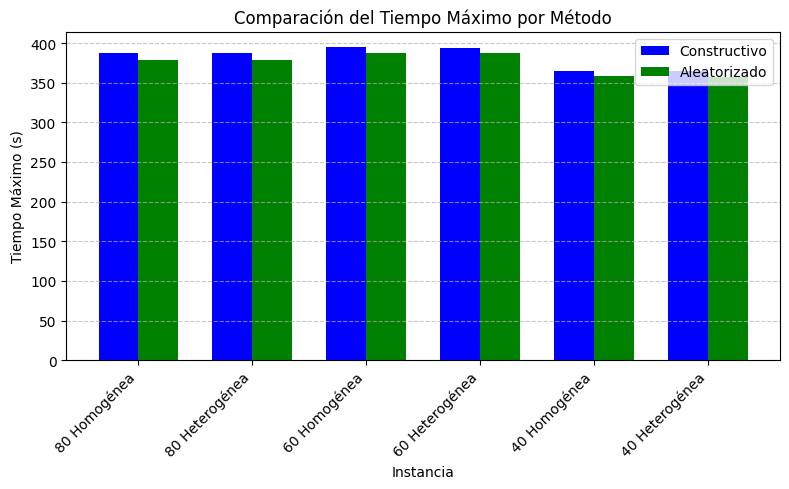

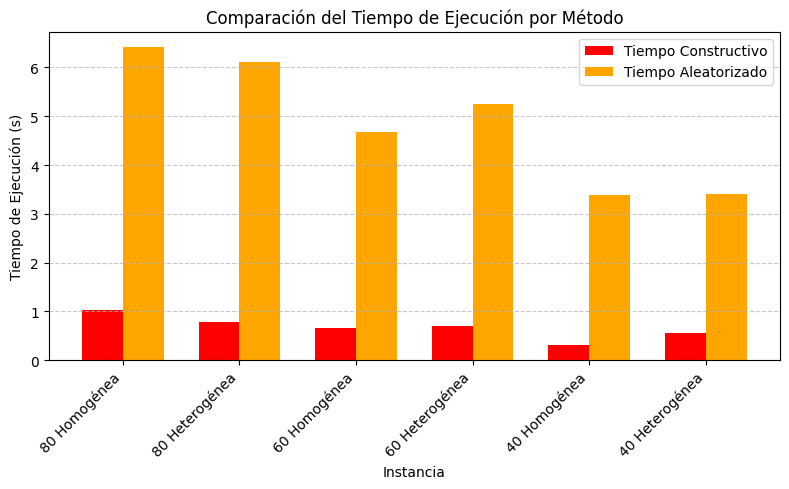

Las gráficas han sido guardadas como 'comparacion_maxima.png' y 'comparacion_tiempo_ejecucion.png'.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de las instancias
instancias = ["80 Homogénea", "80 Heterogénea", "60 Homogénea", "60 Heterogénea", "40 Homogénea", "40 Heterogénea"]

# Tiempos máximos en segundos
constructivo = [387.64, 387.86, 394.45, 394.01, 364.31, 364.68]
aleatorizado = [378.86, 378.56, 387.86, 388.06, 358.32, 357.67]

# Tiempos de ejecución
tiempo_constructivo = [1.03, 0.78, 0.66, 0.71, 0.32, 0.56]
tiempo_aleatorizado = [6.41, 6.12, 4.68, 5.26, 3.39, 3.41]

# Crear gráfico de comparación de tiempos máximos
plt.figure(figsize=(8, 5))
x = np.arange(len(instancias))
width = 0.35

plt.bar(x - width/2, constructivo, width, label="Constructivo", color="blue")
plt.bar(x + width/2, aleatorizado, width, label="Aleatorizado", color="green")

plt.xlabel("Instancia")
plt.ylabel("Tiempo Máximo (s)")
plt.title("Comparación del Tiempo Máximo por Método")
plt.xticks(ticks=x, labels=instancias, rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Guardar gráfico
plt.tight_layout()
plt.savefig("comparacion_maxima.png", dpi=300)
plt.show()

# Crear gráfico de comparación de tiempos de ejecución
plt.figure(figsize=(8, 5))

plt.bar(x - width/2, tiempo_constructivo, width, label="Tiempo Constructivo", color="red")
plt.bar(x + width/2, tiempo_aleatorizado, width, label="Tiempo Aleatorizado", color="orange")

plt.xlabel("Instancia")
plt.ylabel("Tiempo de Ejecución (s)")
plt.title("Comparación del Tiempo de Ejecución por Método")
plt.xticks(ticks=x, labels=instancias, rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Guardar gráfico
plt.tight_layout()
plt.savefig("comparacion_tiempo_ejecucion.png", dpi=300)
plt.show()

print("Las gráficas han sido guardadas como 'comparacion_maxima.png' y 'comparacion_tiempo_ejecucion.png'.")
